In [1]:
import os
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
from skimage.feature import hog
from skimage import feature
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.svm import SVC
import joblib
import json
import random
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns

import glob

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE


from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, label_binarize

from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support, roc_curve, auc
from sklearn.model_selection import cross_val_score, StratifiedKFold
from torchvision.transforms import ToPILImage

In [2]:
# --- Enhancements: imports for fast SVM / multi-label ---
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score, classification_report, f1_score
from sklearn.utils.multiclass import type_of_target
from scipy.sparse import issparse
import numpy as np, time, os, json, joblib

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from scipy.sparse import issparse
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report
import os, glob, joblib, pandas as pd


In [ ]:
# Paths
root_path = os.path.join('..', 'dataset', 'malaria')
train_base_path = os.path.join(root_path, 'training_ds')
test_base_path = os.path.join(root_path, 'testing_ds')

# --- NEW: Create a directory to store the trained models ---
MODELS_DIR = os.path.join('.', 'trained_models')
os.makedirs(MODELS_DIR, exist_ok=True)


FEATURES_DIR = os.path.join(root_path, 'extracted_features')
os.makedirs(FEATURES_DIR, exist_ok=True)

image_sizes = [128]
print("Root Path:", root_path)
print("Train Base Path:", train_base_path)
print("Test Base Path:", test_base_path)

Root Path: ..\dataset\malaria
Train Base Path: ..\dataset\malaria\training_ds
Test Base Path: ..\dataset\malaria\testing_ds


### Model Training

In [ ]:
experiment_results = []
feature_files = glob.glob(os.path.join(FEATURES_DIR, "*.pkl"))

if not feature_files:
    print("ERROR: No feature files found!")
    print(f"Please run the Feature Extraction cell first to create .pkl files in: {FEATURES_DIR}")

# --- Main Training Loop ---
for file_path in feature_files:
    filename = os.path.basename(file_path)
    size, extractor_name, _ = filename.split('_', 2)
    
    print(f"\n{'='*25}")
    print(f"RUNNING EXPERIMENT")
    print(f"Image Size: {size}x{size} | Feature Extractor: {extractor_name}")
    print(f"{'='*25}")
    
    # --- 1. Load Pre-computed Feature Data ---
    data = joblib.load(file_path)
    X_train, y_train = data['X_train'], data['y_train']
    X_test,  y_test  = data['X_test'],  data['y_test']
    le = data['label_encoder']

    # --- 2. Build, Train, or Load the Pipeline ---
    model_path = os.path.join(MODELS_DIR, f"{size}_{extractor_name}_model.pkl")

    if os.path.exists(model_path):
        print(f"Loading pre-trained model from: {model_path}")
        pipeline = joblib.load(model_path)
    else:
        print("Pre-trained model not found. Training a new model...")

        # Scale safely for sparse/dense inputs
        scaler = StandardScaler(with_mean=not issparse(X_train))

        # Use imblearn Pipeline so SMOTE is applied ONLY during fit on the training data
        pipeline = ImbPipeline(steps=[
            ('scaler', scaler),                       # scale features (fit on train only)
            ('smote', SMOTE(random_state=42)),        # resample minority classes (train only)
            ('svm', SVC(kernel='rbf',
                        C=10,
                        gamma=0.01,
                        class_weight='balanced',      # fight majority (e.g., RBC) dominance
                        cache_size=1000,              # speed up kernel cache (MB)
                        max_iter=10000,               # cap to avoid endless training
                        random_state=42))
        ])

        pipeline.fit(X_train, y_train)

        print(f"Saving trained model to: {model_path}")
        joblib.dump(pipeline, model_path)

    # --- 3. Evaluation ---
    print("\n--- Evaluation Results ---")
    predictions = pipeline.predict(X_test)
    report = classification_report(y_test, predictions, target_names=le.classes_, output_dict=True)
    print(classification_report(y_test, predictions, target_names=le.classes_))

    # --- 4. Store Results for Final Summary ---
    experiment_results.append({
        'image_size': size,
        'feature_extractor': extractor_name,
        'accuracy': report.get('accuracy', None),
        'f1_score_weighted': report['weighted avg']['f1-score']
    })

# --- 5. Display Final Summary Table (fixed indentation) ---
if experiment_results:
    print(f"\n{'='*30}")
    print("FINAL EXPERIMENT SUMMARY")
    print(f"{'='*30}")
    results_df = pd.DataFrame(experiment_results)

    sort_key = None
    for key in ['f1_score_weighted','macro_f1','micro_f1','accuracy']:
        if key in results_df.columns:
            sort_key = key
            break
    if sort_key is not None:
        results_df = results_df.sort_values(by=sort_key, ascending=False)

    display(results_df)
    
    summary_path = 'model_experiment_summary.csv'
    results_df.to_csv(summary_path, index=False)
    print(f"\nSummary saved to {summary_path}")



RUNNING EXPERIMENT
Image Size: 128x128 | Feature Extractor: HIST
Pre-trained model not found. Training a new model...


c:\Users\shera\miniconda3\envs\fyp2\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Saving trained model to: .\trained_models2\128_HIST_model.pkl

--- Evaluation Results ---


c:\Users\shera\miniconda3\envs\fyp2\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\shera\miniconda3\envs\fyp2\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\shera\miniconda3\envs\fyp2\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape

                precision    recall  f1-score   support

     difficult       0.40      0.12      0.19        16
    gametocyte       0.00      0.00      0.00        14
     leukocyte       1.00      0.38      0.55        21
red_blood_cell       0.95      1.00      0.98      6869
          ring       0.25      0.01      0.01       173
      schizont       0.00      0.00      0.00        12
   trophozoite       0.76      0.26      0.39       168

      accuracy                           0.95      7273
     macro avg       0.48      0.25      0.30      7273
  weighted avg       0.93      0.95      0.93      7273


RUNNING EXPERIMENT
Image Size: 128x128 | Feature Extractor: HOG
Pre-trained model not found. Training a new model...


c:\Users\shera\miniconda3\envs\fyp2\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Saving trained model to: .\trained_models2\128_HOG_model.pkl

--- Evaluation Results ---


c:\Users\shera\miniconda3\envs\fyp2\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\shera\miniconda3\envs\fyp2\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\shera\miniconda3\envs\fyp2\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape

                precision    recall  f1-score   support

     difficult       0.00      0.00      0.00        16
    gametocyte       0.00      0.00      0.00        14
     leukocyte       0.00      0.00      0.00        21
red_blood_cell       0.94      1.00      0.97      6869
          ring       0.00      0.00      0.00       173
      schizont       0.00      0.00      0.00        12
   trophozoite       0.00      0.00      0.00       168

      accuracy                           0.94      7273
     macro avg       0.13      0.14      0.14      7273
  weighted avg       0.89      0.94      0.92      7273


RUNNING EXPERIMENT
Image Size: 128x128 | Feature Extractor: LBP
Pre-trained model not found. Training a new model...


c:\Users\shera\miniconda3\envs\fyp2\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Saving trained model to: .\trained_models2\128_LBP_model.pkl

--- Evaluation Results ---
                precision    recall  f1-score   support

     difficult       0.01      0.38      0.02        16
    gametocyte       0.01      0.14      0.03        14
     leukocyte       0.15      0.67      0.25        21
red_blood_cell       0.99      0.85      0.91      6869
          ring       0.17      0.08      0.10       173
      schizont       0.01      0.08      0.01        12
   trophozoite       0.24      0.39      0.29       168

      accuracy                           0.82      7273
     macro avg       0.23      0.37      0.23      7273
  weighted avg       0.94      0.82      0.87      7273


FINAL EXPERIMENT SUMMARY


,image_size,feature_extractor,accuracy,f1_score_weighted
0,128,HIST,0.951052,0.932698
1,128,HOG,0.944452,0.917472
2,128,LBP,0.815757,0.872467



Summary saved to model_experiment_summary.csv


In [5]:
# --- NEW: Create a directory to store the trained models ---
MODELS_DIR = os.path.join('.', 'trained_models')
os.makedirs(MODELS_DIR, exist_ok=True)

experiment_results = []
feature_files = glob.glob(os.path.join(FEATURES_DIR, "*.pkl"))

if not feature_files:
    print("ERROR: No feature files found!")
    print(f"Please run the Feature Extraction cell first to create .pkl files in: {FEATURES_DIR}")

# --- Main Training Loop ---
for file_path in feature_files:
    filename = os.path.basename(file_path)
    size, extractor_name, _ = filename.split('_', 2)
    
    print(f"\n{'='*25}")
    print(f"RUNNING EXPERIMENT")
    print(f"Image Size: {size}x{size} | Feature Extractor: {extractor_name}")
    print(f"{'='*25}")
    
    # --- 1. Load Pre-computed Feature Data ---
    data = joblib.load(file_path)
    X_train, y_train = data['X_train'], data['y_train']
    X_test, y_test = data['X_test'], data['y_test']
    le = data['label_encoder']
    
    # --- 2. Build, Train, or Load the Pipeline ---
    model_path = os.path.join(MODELS_DIR, f"{size}_{extractor_name}_model.pkl")

    # --- NEW: Check if the model is already trained ---
    if os.path.exists(model_path):
        print(f"Loading pre-trained model from: {model_path}")
        pipeline = joblib.load(model_path)
    else:
        # If model not found, define the pipeline and train it
        print("Pre-trained model not found. Training a new model...")
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('smote', SMOTE(random_state=42)),
            ('svm', SVC(kernel='rbf', C=10, gamma=0.01, random_state=42))
        ])
        
        pipeline.fit(X_train, y_train) # This is the training line
        
        # --- NEW: Save the newly trained pipeline ---
        print(f"Saving trained model to: {model_path}")
        joblib.dump(pipeline, model_path)

    # --- 3. Evaluation ---
    print("\n--- Evaluation Results ---")
    predictions = pipeline.predict(X_test)
    report = classification_report(y_test, predictions, target_names=le.classes_, output_dict=True)
    print(classification_report(y_test, predictions, target_names=le.classes_))

    # --- 4. Store Results for Final Summary ---
    experiment_results.append({
        'image_size': size,
        'feature_extractor': extractor_name,
        'accuracy': report['accuracy'],
        'f1_score_weighted': report['weighted avg']['f1-score']
    })

# --- 5. Display Final Summary Table ---
if experiment_results:
    print(f"\n{'='*30}")
    print("FINAL EXPERIMENT SUMMARY")
    print(f"{'='*30}")
    results_df = pd.DataFrame(experiment_results)
    sort_key = None
for key in ['f1_score_weighted','macro_f1','micro_f1','accuracy']:
    if key in results_df.columns:
        sort_key = key; break
if sort_key is not None:
    results_df = results_df.sort_values(by=sort_key, ascending=False)

    display(results_df)
    
    summary_path = 'model_experiment_summary.csv'
    results_df.to_csv(summary_path, index=False)
    print(f"\nSummary saved to {summary_path}")


RUNNING EXPERIMENT
Image Size: 128x128 | Feature Extractor: HIST
Loading pre-trained model from: .\trained_models\128_HIST_model.pkl

--- Evaluation Results ---


c:\Users\shera\miniconda3\envs\fyp2\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\shera\miniconda3\envs\fyp2\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\shera\miniconda3\envs\fyp2\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape

                precision    recall  f1-score   support

     difficult       0.40      0.12      0.19        16
    gametocyte       0.00      0.00      0.00        14
     leukocyte       1.00      0.38      0.55        21
red_blood_cell       0.95      1.00      0.98      6869
          ring       0.25      0.01      0.01       173
      schizont       0.00      0.00      0.00        12
   trophozoite       0.76      0.26      0.39       168

      accuracy                           0.95      7273
     macro avg       0.48      0.25      0.30      7273
  weighted avg       0.93      0.95      0.93      7273


RUNNING EXPERIMENT
Image Size: 128x128 | Feature Extractor: HOG
Pre-trained model not found. Training a new model...


TypeError: All intermediate steps should be transformers and implement fit and transform or be the string 'passthrough' 'SMOTE(random_state=42)' (type <class 'imblearn.over_sampling._smote.base.SMOTE'>) doesn't

In [ ]:
# # --- SVM ---
# print("\n--- Training SVM ---")
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)
# svm_model = SVC(kernel='rbf', C=1.0, random_state=42, class_weight='balanced', probability=True)
# svm_model.fit(X_train_scaled, y_train)
# svm_preds = svm_model.predict(X_test_scaled)
# print("\n--- SVM Evaluation ---")
# print(f"Accuracy: {accuracy_score(y_test, svm_preds):.4f}")
# print(classification_report(y_test, svm_preds, target_names=le.classes_))

In [ ]:
# Save model + scaler + label encoder
joblib.dump(svm_model, "svm_model.pkl")
joblib.dump(scaler, "scaler.pkl")
joblib.dump(le, "label_encoder.pkl")


NameError: name 'svm_model' is not defined

In [ ]:
import joblib

# Load saved objects
svm_model = joblib.load("svm_model.pkl")
scaler = joblib.load("scaler.pkl")
le = joblib.load("label_encoder.pkl")

# Example: predicting on new images
new_im = os.path.join(image_path, '0a7bfa8a-ee52-4f7a-b9c5-2919ecfa93ef.png')
print(root_path)
new_im = os.path.join(root_path,'resized_images_by_classes', 'gametocyte', '0d3c2521-da55-4df5-bf06-56b3bd4fb2fc_cell_29_gametocyte.png')
features = feature_extractor(new_im)
features_scaled = scaler.transform([features])
pred = svm_model.predict(features_scaled)
pred_label = le.inverse_transform(pred)

print("Predicted class:", pred_label[0])


..\dataset\malaria
Predicted class: gametocyte


## Sliding Window Code

Loading model and utilities...
Scanning image with sliding window...
Found 4 potential detections. Applying NMS...
Displaying 3 final detections.


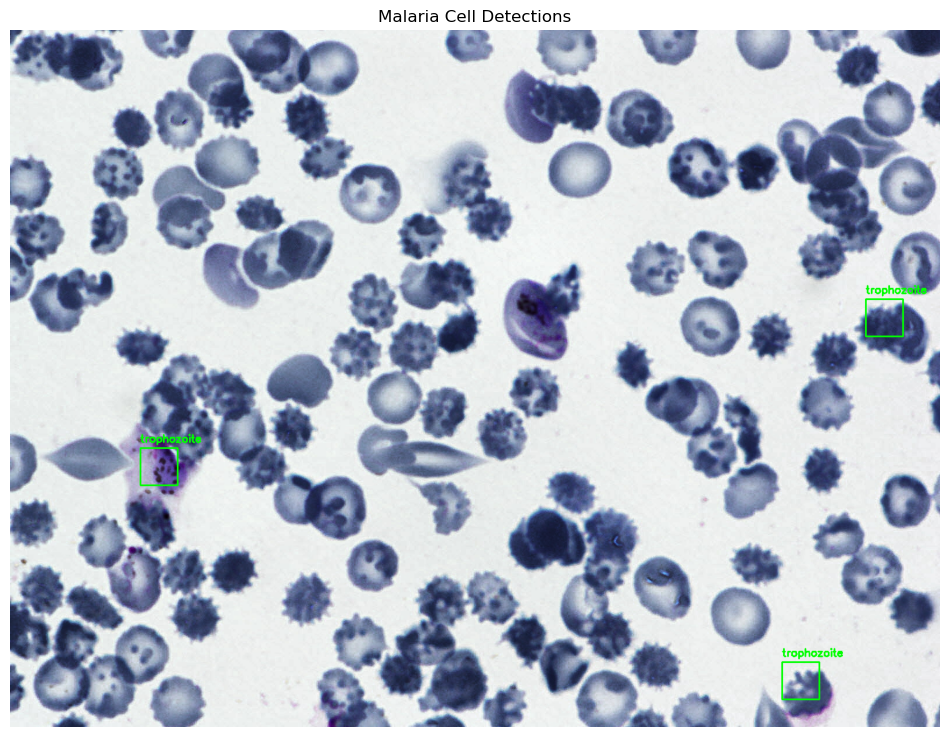

In [ ]:
import cv2
import joblib
import numpy as np
from skimage.feature import hog
from matplotlib import pyplot as plt

# --- HELPER FUNCTION FOR SLIDING WINDOW ---
def sliding_window(image, step_size, window_size):
    # slide a window across the image
    for y in range(0, image.shape[0] - window_size[1], step_size):
        for x in range(0, image.shape[1] - window_size[0], step_size):
            # yield the current window
            yield (x, y, image[y:y + window_size[1], x:x + window_size[0]])

# --- HELPER FUNCTION FOR NON-MAXIMUM SUPPRESSION ---
def non_max_suppression(boxes, scores, overlap_thresh):
    if len(boxes) == 0:
        return []
    
    # Convert boxes to float for calculations
    boxes = np.array(boxes, dtype="float")
    
    pick = []
    x1 = boxes[:,0]
    y1 = boxes[:,1]
    x2 = boxes[:,2]
    y2 = boxes[:,3]

    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(scores)

    while len(idxs) > 0:
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)

        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])

        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)

        overlap = (w * h) / area[idxs[:last]]

        idxs = np.delete(idxs, np.concatenate(([last], np.where(overlap > overlap_thresh)[0])))

    return pick


# --- MAIN DETECTION SCRIPT ---

# 1. LOAD MODEL AND UTILS
print("Loading model and utilities...")
svm_model = joblib.load("svm_model.pkl")
scaler = joblib.load("scaler.pkl")
le = joblib.load("label_encoder.pkl")

# 2. DEFINE PARAMETERS
# !!! TUNE THESE PARAMETERS FOR YOUR DATASET !!!
WINDOW_SIZE = (64, 64) # Must be tuned to the size of cells in your images
STRIDE = 16
CONFIDENCE_THRESHOLD = 0.5 # Only keep predictions with high confidence
NMS_THRESHOLD = 0.3 # Threshold for merging overlapping boxes

# 3. LOAD THE TARGET IMAGE
# Replace with the path to your full blood smear image
image_path = os.path.join(root_path, 'images', '0a7bfa8a-ee52-4f7a-b9c5-2919ecfa93ef.png') 
image = cv2.imread(image_path)
if image is None:
    print(f"Error: Could not load image at {image_path}")
    exit()

# We will draw on a copy
output_image = image.copy()

# Lists to store detection results before NMS
detections = []
scores = []

# 4. SLIDING WINDOW LOOP
print("Scanning image with sliding window...")
for (x, y, patch) in sliding_window(image, step_size=STRIDE, window_size=WINDOW_SIZE):
    # Ensure the patch has the correct dimensions
    if patch.shape[0] != WINDOW_SIZE[1] or patch.shape[1] != WINDOW_SIZE[0]:
        continue

    # --- Feature Extraction (MUST MATCH TRAINING) ---
    gray_patch = cv2.cvtColor(patch, cv2.COLOR_BGR2GRAY)
    resized_patch = cv2.resize(gray_patch, (128, 128)) # Resize to match training
    
    features = hog(resized_patch, pixels_per_cell=(16, 16),
                   cells_per_block=(2, 2), visualize=False)
    
    # Scale features
    features_scaled = scaler.transform([features])
    
    # Predict probability
    probabilities = svm_model.predict_proba(features_scaled)[0]
    prediction_idx = np.argmax(probabilities)
    confidence = probabilities[prediction_idx]

    # --- Check if prediction is confident and not a background class ---
    predicted_label = le.inverse_transform([prediction_idx])[0]

    if confidence > CONFIDENCE_THRESHOLD and predicted_label != 'red_blood_cell':
        # Store the bounding box and the score
        box = (x, y, x + WINDOW_SIZE[0], y + WINDOW_SIZE[1])
        detections.append(box)
        scores.append(confidence)
        # For visualization, you might want to store the label too
        # For NMS, we primarily need boxes and scores

# 5. APPLY NON-MAXIMUM SUPPRESSION
print(f"Found {len(detections)} potential detections. Applying NMS...")
final_indices = non_max_suppression(detections, scores, NMS_THRESHOLD)
final_boxes = [detections[i] for i in final_indices]

# 6. DRAW FINAL BOUNDING BOXES
print(f"Displaying {len(final_boxes)} final detections.")
for box in final_boxes:
    # Re-predict to get the label for the final box (or store it earlier)
    (startX, startY, endX, endY) = box
    patch = image[startY:endY, startX:endX]
    gray_patch = cv2.cvtColor(patch, cv2.COLOR_BGR2GRAY)
    resized_patch = cv2.resize(gray_patch, (128, 128))
    features = hog(resized_patch, pixels_per_cell=(16, 16), cells_per_block=(2, 2), visualize=False)
    features_scaled = scaler.transform([features])
    pred = svm_model.predict(features_scaled)
    pred_label = le.inverse_transform(pred)[0]

    # Draw the box and label
    cv2.rectangle(output_image, (startX, startY), (endX, endY), (0, 255, 0), 2)
    label_text = f"{pred_label}"
    cv2.putText(output_image, label_text, (startX, startY - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

# Display the result
plt.figure(figsize=(12, 12))
plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
plt.title("Malaria Cell Detections")
plt.axis('off')
plt.show()

NameError: name 'X' is not defined

In [ ]:
print("\n--- Training SVM (enhanced) ---")

def _is_multilabel(y):
    try:
        tt = type_of_target(y)
        return tt in ("multilabel-indicator", "multilabel-sequences")
    except Exception:
        return isinstance(y, (list, tuple)) and len(y)>0 and isinstance(y[0], (list, tuple, set))

# Expect: X_train, X_test, y_train, y_test already defined by your existing pipeline
multilabel = _is_multilabel(y_train)

if multilabel:
    print("Detected MULTI-LABEL → OneVsRest(LinearSVC) with probability calibration")
    # Ensure indicator matrices + class names
    if not (hasattr(y_train, "ndim") and y_train.ndim==2):
        mlb = MultiLabelBinarizer()
        Y_train = mlb.fit_transform(y_train)
        Y_test  = mlb.transform(y_test)
        class_names = list(mlb.classes_)
    else:
        Y_train, Y_test = y_train, y_test
        class_names = [str(i) for i in range(Y_train.shape[1])]

    scaler = StandardScaler(with_mean=not issparse(X_train))
    base = LinearSVC(
        C=1.0,
        class_weight="balanced",
        dual=(X_train.shape[0] < X_train.shape[1]),
        max_iter=5000,
        tol=1e-3,
        random_state=42,
    )
    ovrcal = OneVsRestClassifier(CalibratedClassifierCV(base, method="sigmoid", cv=3), n_jobs=-1)
    pipe = Pipeline([("scaler", scaler), ("clf", ovrcal)])

    t0 = time.perf_counter()
    pipe.fit(X_train, Y_train)
    print(f"Trained in {time.perf_counter()-t0:.1f}s")

    P_test = pipe.predict_proba(X_test)
    # Per-class thresholds (simple default). If RBC clutters, bump its threshold.
    thresholds = {name: 0.5 for name in class_names}
    if "RBC" in thresholds:
        thresholds["RBC"] = 0.95

    thr_vec = np.array([thresholds[c] for c in class_names])[None, :]
    Y_pred = (P_test >= thr_vec).astype(int)

    macro_f1 = f1_score(Y_test, Y_pred, average="macro", zero_division=0)
    micro_f1 = f1_score(Y_test, Y_pred, average="micro", zero_division=0)
    print(f"[SVM Multi-label] macroF1={macro_f1:.4f} | microF1={micro_f1:.4f}")

    # Save
    model_path = os.path.join(MODELS_DIR, f"ovr_linsvc_cal_{extractor_name}.joblib")
    joblib.dump(pipe, model_path)
    if "mlb" in locals():
        joblib.dump(mlb, os.path.join(MODELS_DIR, f"mlb_{extractor_name}.joblib"))
    with open(os.path.join(MODELS_DIR, f"thresholds_{extractor_name}.json"), "w") as f:
        json.dump({"class_names": class_names, "thresholds": thresholds}, f, indent=2)
    print(f"Saved model and thresholds for {extractor_name}")

    # Log result if the notebook collects them
    try:
        experiment_results.append({
            "extractor": extractor_name,
            "model": "LinearSVC+Calib OvR",
            "macro_f1": float(macro_f1),
            "micro_f1": float(micro_f1),
            "model_path": model_path,
        })
    except Exception:
        pass

else:
    print("Detected SINGLE-LABEL → fast LinearSVC (replaces slow RBF SVC)")
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    clf = LinearSVC(
        C=1.0,
        class_weight="balanced",
        dual=(X_train.shape[0] < X_train.shape[1]),
        max_iter=5000,
        tol=1e-3,
        random_state=42,
    )
    t0 = time.perf_counter()
    clf.fit(X_train_scaled, y_train)
    print(f"Trained in {time.perf_counter()-t0:.1f}s")

    svm_preds = clf.predict(X_test_scaled)
    print(f"Accuracy: {accuracy_score(y_test, svm_preds):.4f}")
    try:
        print(classification_report(y_test, svm_preds, target_names=le.classes_))
    except Exception:
        print(classification_report(y_test, svm_preds))

    # Save as a pipeline (scaler + clf)
    from sklearn.pipeline import Pipeline as _P
    pipe = _P([("scaler", StandardScaler()), ("clf", clf)])
    model_path = os.path.join(MODELS_DIR, f"linear_svc_{extractor_name}.joblib")
    joblib.dump(pipe, model_path)
    print(f"Saved model for {extractor_name} -> {model_path}")

    # Log result if collected
    try:
        experiment_results.append({
            "extractor": extractor_name,
            "model": "LinearSVC",
            "accuracy": float(accuracy_score(y_test, svm_preds)),
            "model_path": model_path,
        })
    except Exception:
        pass

NameError: name 'LabelEncoder' is not defined